In [2]:
import psycopg2
import pandas as pd

db_endpoint = "postgres-1.clmlqirmvrik.eu-central-1.rds.amazonaws.com"
db_port = 5432
db_name = "OPA_project"
db_user = "postgres"
db_password = "datascientest"

# Parameters
param_dic = {
    "host"      : db_endpoint,
    "database"  : db_name,
    "user"      : db_user,
    "password"  : db_password,
    "port"      : db_port
}


def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tuples
    tuples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tuples, columns=column_names)
    return df

# Connect to the database
conn = connect(param_dic)
# column_names = ["my", "column", "names"]




Connecting to the PostgreSQL database...
Connection successful


In [4]:
column_names = ["date", "open", "high", "low", "close", "adjclose", "volume", "ticker", "currency_id"]
# Execute the "SELECT *" query

df = postgresql_to_dataframe(conn, "select * from crypto_daily_rates_hist", column_names = column_names)

In [16]:
df.columns
cols_float = ["open", "high", "low", "close", "adjclose", "volume"]

for col in cols_float:
    df[col] = df[col].astype(float)

df["ticker"] = df["ticker"] .astype(str)
df["currency_id"] = df["currency_id"] .astype(str)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4072 non-null   datetime64[ns]
 1   open         4052 non-null   float64       
 2   high         4052 non-null   float64       
 3   low          4052 non-null   float64       
 4   close        4052 non-null   float64       
 5   adjclose     4052 non-null   float64       
 6   volume       4052 non-null   float64       
 7   ticker       4072 non-null   object        
 8   currency_id  4072 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 286.4+ KB


,date,open,high,low,close,adjclose,volume,ticker,currency_id
0,2023-01-01,16547.914062,16630.439453,16521.234375,16625.080078,16625.080078,9.244362e+09,btc-usd,btc
1,2023-01-02,16625.509766,16759.343750,16572.228516,16688.470703,16688.470703,1.209778e+10,btc-usd,btc
2,2023-01-03,16688.847656,16760.447266,16622.371094,16679.857422,16679.857422,1.390308e+10,btc-usd,btc
3,2023-01-04,16680.205078,16964.585938,16667.763672,16863.238281,16863.238281,1.842174e+10,btc-usd,btc
4,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,1.369276e+10,btc-usd,btc


Now we want to consider prices of btc only

In [17]:
df_btc = df[df["ticker"]=="btc-usd"]

In [20]:
df_btc.info()


<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 0 to 207
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         208 non-null    datetime64[ns]
 1   open         207 non-null    float64       
 2   high         207 non-null    float64       
 3   low          207 non-null    float64       
 4   close        207 non-null    float64       
 5   adjclose     207 non-null    float64       
 6   volume       207 non-null    float64       
 7   ticker       208 non-null    object        
 8   currency_id  208 non-null    object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 16.2+ KB


(208, 9)

There's only one NA value, we drop the row
We drop irrelevant columns
We also need to make the date column an index

In [ ]:
# convert date into index
df_btc.set_index('date', inplace=True)

In [26]:
# drop NA
df_btc = df_btc.dropna()

# drop irreleant columns
df_btc.drop('ticker', axis=1, inplace=True)
df_btc.drop('currency_id', axis=1, inplace=True)



/var/folders/t8/kr4v_qtd3x58n4sy1dgf12zr0000gn/T/ipykernel_75456/2801064791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc.drop('ticker', axis=1, inplace=True)
/var/folders/t8/kr4v_qtd3x58n4sy1dgf12zr0000gn/T/ipykernel_75456/2801064791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc.drop('currency_id', axis=1, inplace=True)


In [60]:
df_btc = df_btc.dropna()


In [29]:
# assuming I want to predict the closing price.
# the other prices are too correlated to close so I will drop them as well and keep close and volume


In [61]:
df_btc.shape

(207, 9)

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


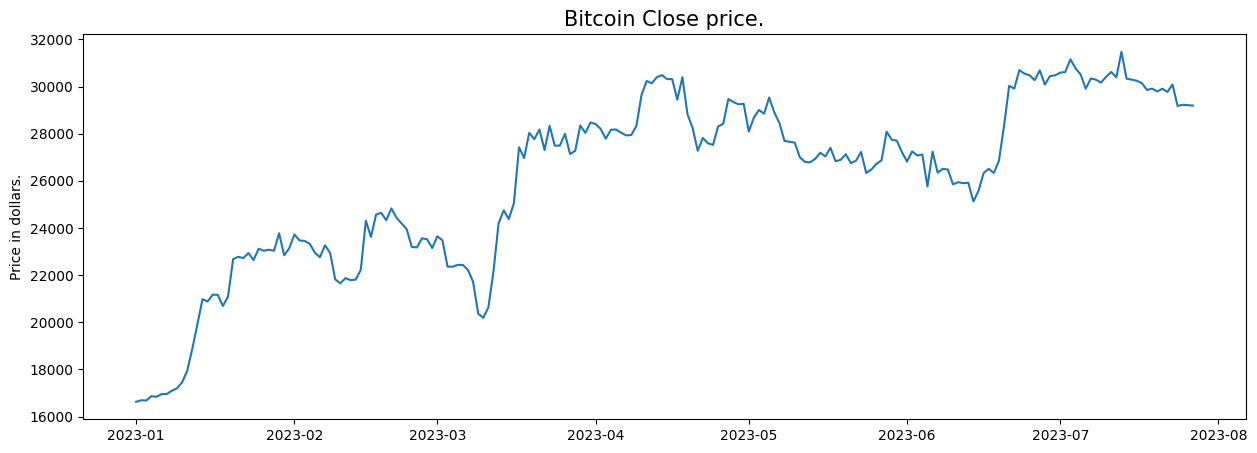

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(df_btc['close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()


In [63]:
df_btc['open-close'] = df_btc['open'] - df_btc['close']
df_btc['low-high'] = df_btc['low'] - df_btc['high']

# This target checks if the closing value of the next day is higher than the current day.
df_btc['target'] = np.where(df_btc['close'].shift(-1) > df_btc['close'], 1, 0)


In [64]:
df_btc.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2023-01-01 to 2023-07-27
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        207 non-null    float64
 1   high        207 non-null    float64
 2   low         207 non-null    float64
 3   close       207 non-null    float64
 4   adjclose    207 non-null    float64
 5   volume      207 non-null    float64
 6   open-close  207 non-null    float64
 7   low-high    207 non-null    float64
 8   target      207 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 16.2 KB


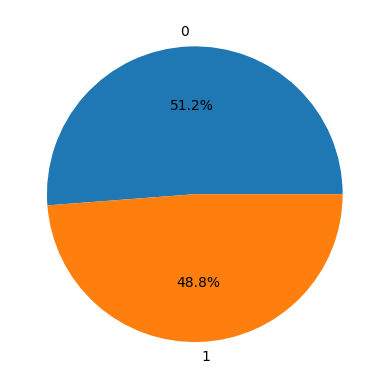

In [65]:
# before proceeding let’s check whether the target is balanced or not using a pie chart.

plt.pie(df_btc['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

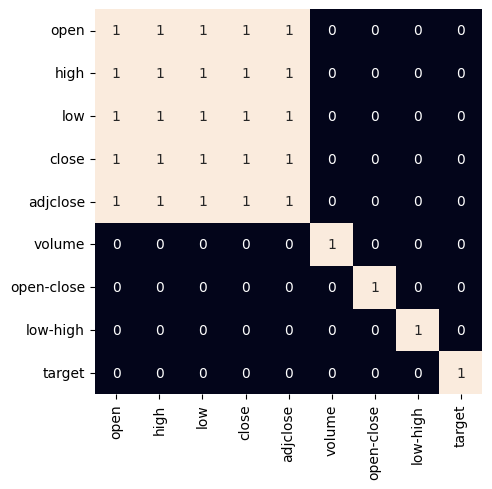

In [66]:
plt.figure(figsize=(5, 5))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df_btc.corr() > 0.9, annot=True, cbar=False)
plt.show()


In [67]:
features = df_btc[['open-close', 'low-high']]
target = df_btc['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, Y_train, Y_test = train_test_split(
	features, target, test_size=0.2, random_state=2022)

print(X_train.shape, X_test.shape)


(165, 2) (42, 2)


In [68]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_test, models[i].predict_proba(X_test)[:,1]))


LogisticRegression() : 
Training Accuracy :  0.56014256014256
Validation Accuracy :  0.5802469135802468
SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.504900504900505
Validation Accuracy :  0.49629629629629635
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accuracy :

open          1
high          1
low           1
close         1
adjclose      1
volume        1
open-close    1
low-high      1
target        0
dtype: int64